# Rejection and importance sampling

The purpose of this session is to see how we can use random numbers to do inference. We start with two very simple Monte Carlo methods, namely rejection sampling and importance sampling. These methods are not often used directly in practice, but they will help you understand many of the important concepts that underlie more sophisticated Monte Carlo methods.

Even though these methods aren't used in practice, rejection sampling gives a nice intuitive explanation of accepting and rejecting proposed samples that will come up again, in a more nuanced form, with more complicated Monte Carlo methods. Importance sampling is often used as part of a more complicated sampler.

## Prep plan

* There are 3 videos to watch on rejection and importance sampling. Watching these should take ~45 minutes in total.
* The rest of your time (60–90 minutes) should be spent on this workbook. Study the data set and model introduced in the workbook and generate samples from it using importance sampling.

## Introduction

In the context of this course, the purpose of Monte Carlo sampling is to do approximate inference in models that we cannot solve analytically. This is how we use PyMC. Understanding the limitations of sampling methods is important for understanding when and why PyMC is or is not working well.

In general, doing inference using Monte Carlo sampling is a difficult problem – especially in models with many variables (high-dimensional models) where we cannot visualize probability density functions and where the posterior might be multimodal, have narrow peaks, and other weird features that we have to discover to get a good idea of how the PDF behaves.

Monte Carlo methods attempt to solve one of two problems.

1. Draw samples from a probability distribution, $p(x)$, where $x$ can be a high-dimensional vector.
2. Approximately compute expected values $E[f(x)]$ under the distribution $p(x)$.

As you will see, solving Problem 1 automatically solves Problem 2, but sometimes it is easier to solve Problem 2 directly without trying to generate samples from $p(x)$.

## Rejection sampling

### Required video

Watch Lambert, B. (2018, May 15). [An introduction to rejection sampling](https://www.youtube.com/watch?v=kYWHfgkRc9s). Youtube. (11 minutes).

**Summary:** This video provides an introduction to and a simple demonstration of rejection sampling. The main takeaways are that, in principle, we can generate samples from any distribution this way but in practice, it is very difficult to do — particularly, when we have a high-dimensional sampling problem. The main focus for today is on importance sampling, which is in the next section below.

## Importance sampling

### Required videos

There are two sets of videos, by two different authors, on importance sampling. You should watch all of them to get the different perspectives and different hints from the two presenters.

* Lambert, B. (2018, May 15). [An introduction to importance sampling](https://www.youtube.com/watch?v=V8f8ueBc9sY). Youtube. (14 minutes)

* Lambert, B. (2018, May 15). [An introduction to importance sampling — optimal importance distributions](https://www.youtube.com/watch?v=F5PdIQxMA28). Youtube. (14 minutes)

**Summary:** The trick of importance sampling is that if we cannot generate samples from a target distribution directly, we can instead generate samples from a different distribution (like a Normal) and compute weights for these samples such that the weighted samples behave as if they come from the target distribution. We can also use the weighted samples to compute any expected value under the target distribution. You should focus on how we should pick the proposal distribution so that our sampler converges well.

## Pre-class work

Carefully read through the problem description below since it forms the basis of the next few lessons on Monte Carlo sampling algorithms. If you have any questions about the problem, be sure to add them to the text field above.

After understanding the problem, work on the tasks after the problem definition.

### Problem definition

We will explore various sampling methods, from today's simple ones to more complicated ones, using the following Bayesian inference problem.

We have a situation where we measure outcomes that are a mixture of two Normal distributions.

* 70% of the data come from a known Normal distribution. We call this the background distribution since we know exactly how it behaves (its mean and standard deviation) and we imagine it as the background noise that obscures the distribution we are really interested in.
* 30% of the data come from an unknown Normal distribution and we would like to estimate its mean $\mu$ and standard deviation $\sigma$. We call this the signal distribution since we are interested in this part of the data source.

Because we have this mixture, the likelihood function for one measurement, $x_i$, is a weighted sum (a mixture) of two normal distributions, with weights of 0.7 and 0.3.

$$p(x_i \mid \mu, \sigma) = 0.7\,\text{Normal}(x_i \mid 0, 4^2) + 0.3\,\text{Normal}(x_i \mid \mu, \sigma^2)$$

Here is what the likelihood function might look like for different values of $\mu$ and $\sigma$ (but remember, we don't know these parameter values). **Run the code cell** and notice that it is sometimes easy to tell where the signal distribution is and sometimes really hard because we can't really distinguish it from the background distribution.

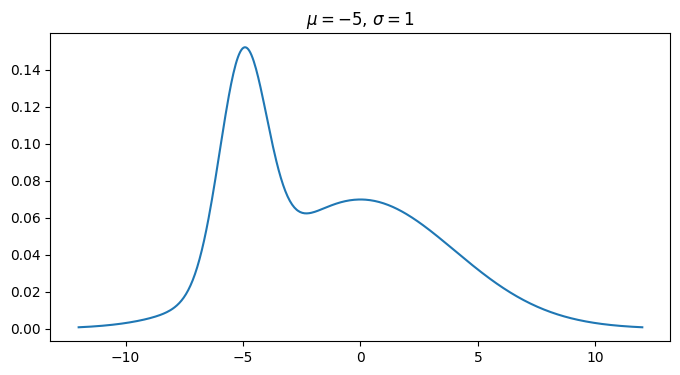

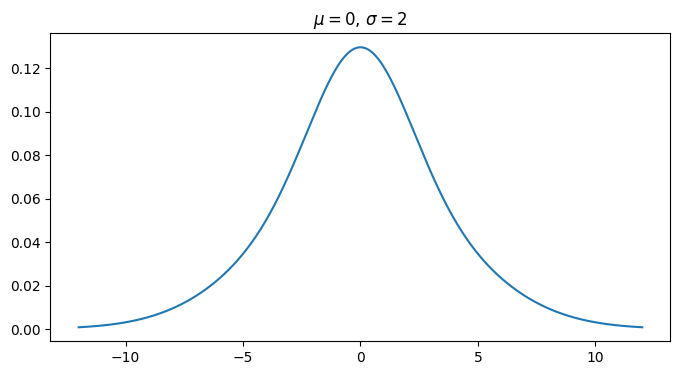

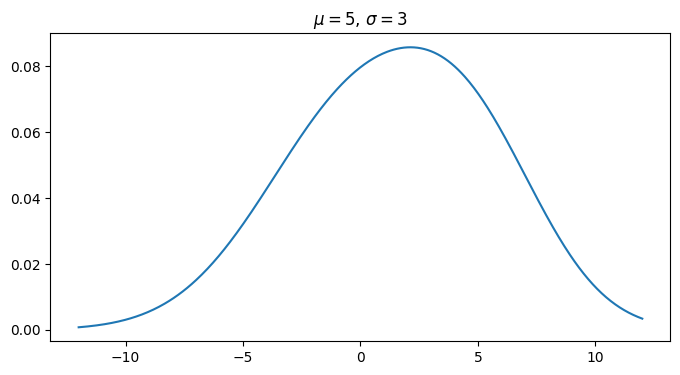

In [1]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt

x = np.linspace(-12, 12, 500)
for mu, sigma in [(-5, 1), (0, 2), (5, 3)]:
    plt.figure(figsize=(8, 4))
    plt.title(rf'$\mu = {mu}$, $\sigma = {sigma}$')
    background = sts.norm.pdf(x, loc=0, scale=4)
    signal = sts.norm.pdf(x, loc=mu, scale=sigma)
    y = (0.7 * background + 0.3 * signal)
    plt.plot(x, y)
plt.show()

### Data

Below is the data set we will use for this problem. About 70% of these data were generated from $\text{Normal}(0, 4^2)$ background distribution and about 30% from $\text{Normal}(\mu, \sigma^2)$ signal distribution. Our goal is to compute the posterior distribution over $\mu$ and $\sigma$.

20


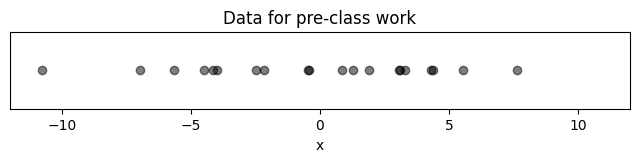

In [2]:
data = np.array([
    -4.127935, -2.152332, 3.046302, -10.77442, -6.985155, 5.536106, 1.294746,
    7.638998, -5.650118, -4.478067, -0.4551435, -3.969413, -0.4225518,
    -2.462094, 1.886675, 3.095567, 4.310003, 3.305034, 0.8548273, 4.368213])

print(len(data))
plt.figure(figsize=(8, 1))
plt.plot(data, [0.05] * len(data), 'ko', alpha=0.5)
plt.xlabel('x')
plt.xticks([-10, -5, 0, 5, 10])
plt.yticks([])
plt.xlim(-12, 12)
plt.title('Data for pre-class work')
plt.show()

Essentially the problem is that we don’t know which of these data were generated from the background distribution, of which we know the mean and variance, and which data were generated from the signal distribution with an unknown mean and variance.

To get a better sense of how difficult it is to determine the unknown mean and variance, the plot below shows the data along with the background distribution. The background distribution seems to account for the data set fairly well. Which data points might have been generated by another normal distribution?

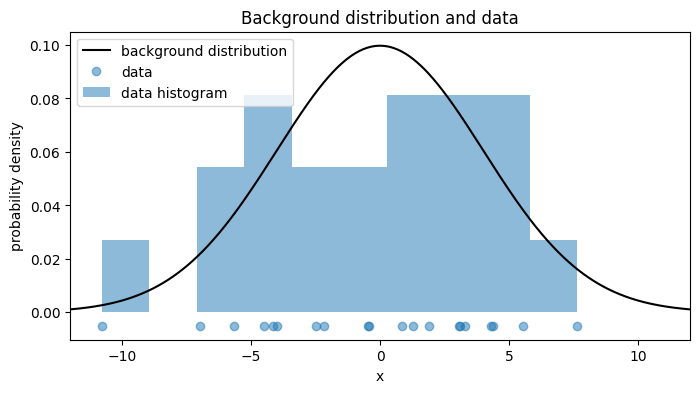

In [3]:
# Plot of the background normal distribution and the data. This shows what we
# know about the model. What we don't know is the other normal distribution.

plot_mu_range = [-12, 12]
plot_sigma_range = [0, 8]

plt.figure(figsize=(8, 4))
plt.title('Background distribution and data')
plot_x = np.linspace(plot_mu_range[0], plot_mu_range[1], 500)
plot_y = sts.norm.pdf(plot_x, loc=0, scale=4)
plt.plot(plot_x, plot_y, 'k-', label='background distribution')
plt.plot(data, [-0.005] * len(data), 'C0o', alpha=0.5, label='data')
plt.hist(data, density=True, color='C0', alpha=0.5, label='data histogram')
plt.xlim(-12, 12)
plt.xlabel('x')
plt.ylabel('probability density')
plt.xticks([-10, -5, 0, 5, 10])
plt.legend()
plt.show()

Looking at the plot of the data above, and knowing that about 70% of the data were generated from the background distribution, what do you think the values of $\mu$ and $\sigma$ are? Explain your estimates.

In [4]:
# ENTER YOUR ANSWER IN FORUM

### Prior

For the purposes of this problem, we will use the following priors:
  * $\mu \sim \text{Normal}(0, 5^2)$
  * $\sigma \sim \text{Gamma}(2, 1)$

### Posterior

The posterior over $\mu$ and $\sigma$ is proportional to the product of the likelihood and the prior.

$$p(\mu, \sigma \mid \{x_i\}) \propto p(\{x_i\} \mid \mu, \sigma) \, p(\mu) \, p(\sigma)$$

$$= \text{Normal}(\mu \mid 0, 5^2) \,\text{Gamma}(\sigma \mid 2, 1) \prod_{i=1}^{20} \left[0.7\,\text{Normal}(x_i \mid 0,4^2) + 0.3\,\text{Normal}(x_i \mid \mu,\sigma^2)\right]$$

Why is it difficult to compute an expected value under this posterior distribution? For example, how would you compute $E(\mu)$ or $E(\sigma)$ and why is it computationally complicated? What happens if you have more data?

In [5]:
# ENTER YOUR ANSWER IN FORUM

### Plot of the unnormalized posterior distribution

Below is a Python function that implements the unnormalized posterior PDF above, along with a 2-d contour plot of the unnormalized posterior.

How does the posterior over $\mu$ and $\sigma$ compare to your best guess for what $\mu$ and $\sigma$ are?

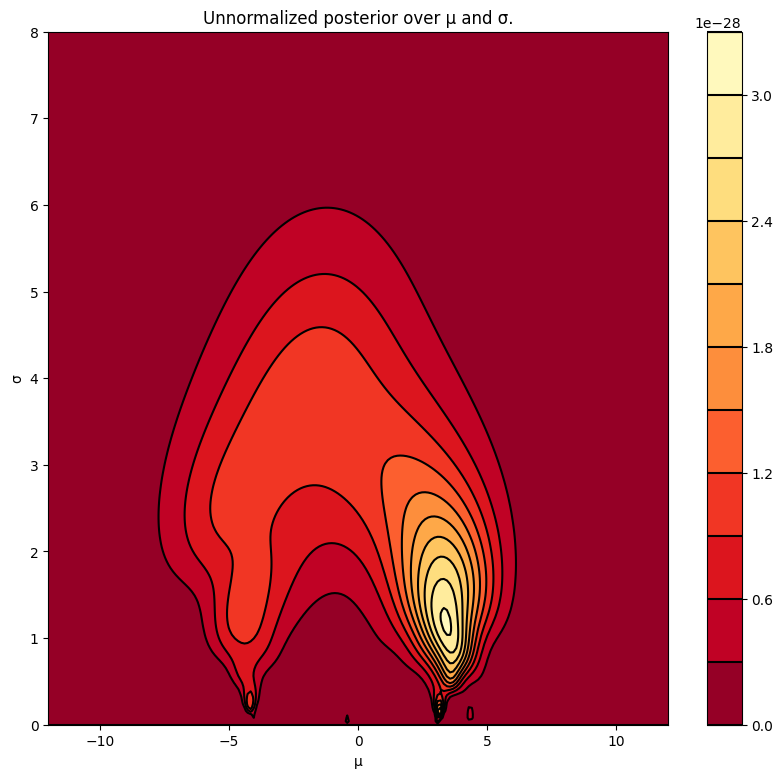

In [12]:
def unnormalized_posterior(mu, sigma, data):
    '''
    The unnormalized posterior pdf over μ and σ. The pdf depends on the
    parameters, `mu` and `sigma`, as well as the `data`.
    '''
    if sigma <= 0:
        # The probability of sigma ≤ 0 is 0. It will become clear why we need
        # need this check a little further down, when we generate samples from
        # a proposal distribution (not the posterior), which might give values
        # of sigma <= 0.
        return 0

    else:
        return (
            sts.gamma.pdf(sigma, a=2, scale=1) *
            sts.norm.pdf(mu, loc=0, scale=5) *
            np.prod(
                0.7 * sts.norm.pdf(data, loc=0, scale=4) +
                0.3 * sts.norm.pdf(data, loc=mu, scale=sigma)))


# Plot of the unormalized posterior using a 2-d contour plot.
mu = np.linspace(plot_mu_range[0], plot_mu_range[1], 200)
sigma = np.linspace(plot_sigma_range[0], plot_sigma_range[1], 200)
posterior = np.empty((len(sigma), len(mu)))
for i in range(len(sigma)):
    for j in range(len(mu)):
        posterior[i,j] = unnormalized_posterior(mu[j], sigma[i], data)

plt.figure(figsize=(10, 9))
filled = plt.contourf(mu, sigma, posterior, 11, cmap=plt.cm.YlOrRd_r)
lines = plt.contour(mu, sigma, posterior, 11, colors='black')
plt.title('Unnormalized posterior over μ and σ.')
plt.xlabel('μ')
plt.ylabel('σ')
color_bar = plt.colorbar(filled)
color_bar.add_lines(lines)
plt.show()

### Task 1

Select a proposal distribution for doing importance sampling on this posterior distribution. Below is an example of a **bad** proposal distribution. Think of a better one and use it to generate samples of $\mu$ and $\sigma$.

Remember that a good proposal distribution should have a lot of probability mass at similar locations to where the true posterior distribution has lots of probability mass.

* Write the code for your proposal distribution in the `good_proposal_rvs` function below.
* Update the plot to show samples from your proposal distribution on the posterior pdf.

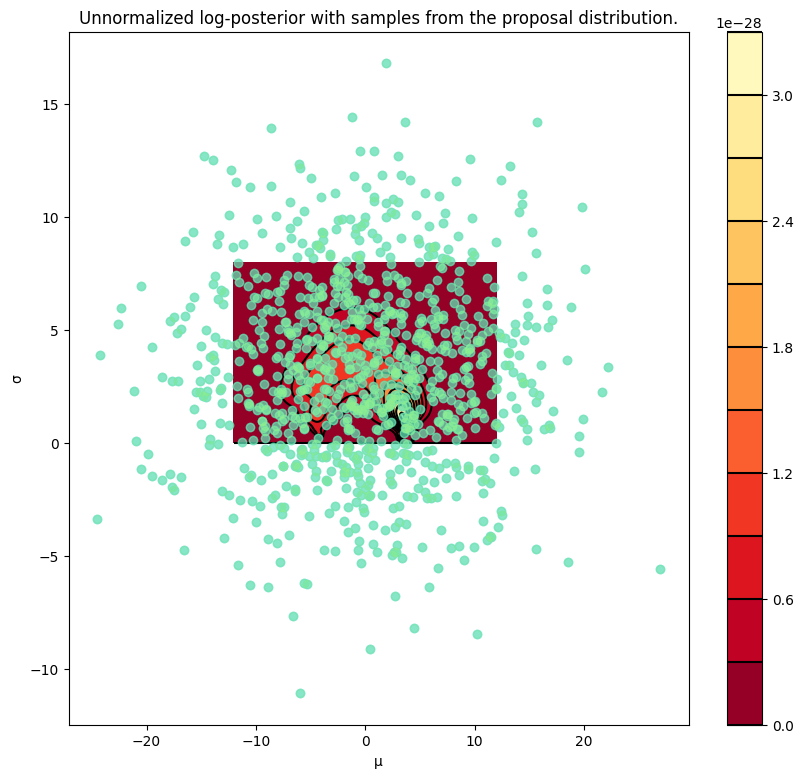

In [13]:
def bad_proposal_rvs(size):
    return {
        'mu': sts.norm.rvs(loc=-5, scale=1.5, size=num_samples),
        'sigma': sts.norm.rvs(loc=2, scale=0.5, size=num_samples)}


# YOUR WORK GOES HERE; PASTE YOUR CODE INTO FORUM


def good_proposal_rvs(size):
    return {
        'mu': sts.norm.rvs(loc=0, scale=8, size=num_samples),
        'sigma': sts.norm.rvs(loc=3, scale=4, size=num_samples)}


# Generate samples
num_samples = 10000

# The bad proposal distribution is a product of independent normal distributions
# over mu and sigma with means [-5, 1.5] and standard deviations [2, 0.5].
samples = good_proposal_rvs(num_samples)

# Plot of the first 1000 samples on the level plot
plt.figure(figsize=(10, 9))
filled = plt.contourf(mu, sigma, posterior, 11, cmap=plt.cm.YlOrRd_r)
lines = plt.contour(mu, sigma, posterior, 11, colors='black')
plt.plot(samples['mu'][:1000], samples['sigma'][:1000], 'o', color='#00c0ff', alpha=0.5)
plt.plot(samples['mu'][:1000], samples['sigma'][:1000], 'o', color='lightgreen', alpha=0.5)
plt.title('Unnormalized log-posterior with samples from the proposal distribution.')
plt.xlabel('μ')
plt.ylabel('σ')
color_bar = plt.colorbar(filled)
color_bar.add_lines(lines)
plt.show()

### Task 2

Once you have your samples, use them to approximate the following—

* The mean and variance of $\mu$.
* The mean and variance of $\sigma$.

Note that you can use the same samples to calculate all four of these values. You do not have to generate new samples every time.

You will have to enter the PDF of your proposal distribution below to calculate the importance weights. Note how the `bad_proposal_pdf` function below matches the `bad_proposal_rvs` function above. You should similarly make `good_proposal_pdf` match `good_proposal_rvs`.

Your answers should approximately match these values:

* $\text{E}(\mu) = -0.3$
* $\text{Var}(\mu) = 13.5$
* $\text{E}(\sigma) = 2.9$
* $\text{Var}(\sigma) = 2.3$

In [14]:
# TASK: Write the pdf of your proposal distribution in this function.
# YOUR WORK GOES HERE; PASTE YOUR CODE INTO FORUM

def bad_proposal_pdf(mu, sigma):
    return (
        sts.norm.pdf(mu, loc=-5, scale=1.5) *
        sts.norm.pdf(sigma, loc=1.5, scale=0.5))


def good_proposal_pdf(mu, sigma):
    return (
        sts.norm.pdf(mu, loc=0, scale=8) *
        sts.norm.pdf(sigma, loc=3, scale=4))


# importance weights to compute expected values under the target distribution.
importance_weights = np.empty(num_samples)
for i in range(num_samples):
    p_value = unnormalized_posterior(samples['mu'][i], samples['sigma'][i], data)
    q_value = good_proposal_pdf(samples['mu'][i], samples['sigma'][i])
    importance_weights[i] = p_value / q_value

In [15]:
sum_weights = np.sum(importance_weights)
normalized_weights = importance_weights / sum_weights

# we divide by the normalized weights (weights divided by the sum of all weights)
mu_mean = np.sum(normalized_weights * samples['mu'])
mu_sq_mean = np.sum(normalized_weights * (samples['mu'] ** 2))
mu_var = mu_sq_mean - (mu_mean ** 2)

sigma_mean = np.sum(normalized_weights * samples['sigma'])
sigma_sq_mean = np.sum(normalized_weights * (samples['sigma'] ** 2))
sigma_var = sigma_sq_mean - (sigma_mean ** 2)

print(f"E(mu) ≈ {mu_mean}")
print(f"Var(mu) ≈ {mu_var}")
print(f"E(sigma) ≈ {sigma_mean}")
print(f"Var(sigma) ≈ {sigma_var}")

E(mu) ≈ -0.3093513839004048
Var(mu) ≈ 13.679861184947265
E(sigma) ≈ 2.8800765604904313
Var(sigma) ≈ 2.316487319458755
